In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
from agents4 import *
from auctions import *
from utils import *
import sys

In [14]:
def find_index(winners, i):
    for j in range(len(winners)):
        if winners[j] == i:
            return j
    return -1

In [15]:
def plot_cumulative_utility(log_utility, bidders):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(log_utility[i], label=bidders[i].get_name(), color=bidders[i].get_color(), linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Cumulative Utility')
    plt.title('Cumulative Utility for Each Bidder')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def plot_cumulative_regret(cumulative_regret, bidders):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(cumulative_regret[i, :], label=bidders[i].get_name(), color=bidders[i].get_color(), linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_per_round_utility(bidders):
    num_bidders = len(bidders)
    num_cols = 4  # Adjust this number based on how many plots per row you want
    num_rows = (num_bidders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration


    for i in range(num_bidders):
        axes[i].plot(bidders[i].utility, color=bidders[i].get_color())
        axes[i].set_title(bidders[i].get_name())
        axes[i].set_xlabel('Round')
        axes[i].set_ylabel('Per-Round Utility')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [18]:
def plot_winning_slots(bidders, lambdas):
    num_bidders = len(bidders)
    num_cols = 4  # Adjust this number based on how many plots per row you want
    num_rows = (num_bidders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(num_bidders):
        _, winning_slots = bidders[i].get_log()
        axes[i].scatter(range(len(winning_slots)),lambdas[winning_slots], alpha =0.3, color=bidders[i].get_color())
        axes[i].set_title(bidders[i].get_name())
        axes[i].set_xlabel('Round')
        axes[i].set_ylabel('Winning Slot')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [19]:
def plot_clairvoyant_vs_actual(clvoy_per_round_utility, bidders, n_users):
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot([clvoy_per_round_utility[i] * n_users] * n_users, label=f'Clairvoyant Bidder {i}', linestyle='--')
        plt.plot(np.cumsum(bidders[i].utility), label=f'Actual Bidder {i}')
    plt.xlabel('Round')
    plt.ylabel('Utility')
    plt.title('Clairvoyant vs Actual Utility')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def plot_bidding(log_bids, bidders):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(log_bids[i], label=bidders[i].get_name(), color=bidders[i].get_color(), linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Bid')
    plt.title('Bid for each Bidder')
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
class Requirement4:
    def __init__(self, params):
        type_of_bidders = 4
        # Parameters of the problem
        self.n_users = params["n_users"]
        self.lambdas = np.sort(np.array(params["lambdas"]))[::-1]
        self.valuations = params["valuations"]
        self.budget = params["budget"]
        self.bidders_per_type = len(self.valuations)
        self.ad_qualities = np.ones(self.bidders_per_type * type_of_bidders )

    def run(self):

        bids_set =  np.linspace(0,1,11) # np.linspace(0,1,int(self.n_users**(1/3)))
        bidders = []
        bids_log = []
        n_slots = len(self.lambdas)

        for i in range( self.bidders_per_type ):
            bidders.append(UCBBiddingAgentExpert( self.valuations[i], bids_set, self.budget, self.n_users ))
            bidders.append(UCBBiddingAgentExpertUpdateRho( self.valuations[i], self.budget, self.n_users ))
            bidders.append(MultiplicativePacingAgent(self.valuations[i], self.budget, self.n_users))
            bidders.append(FFMultiplicativePacingAgent(bids_set, self.valuations[i], self.budget, self.n_users))

        n_bidders = len(bidders)
        actual_utilities = np.zeros((self.n_users, n_bidders))

        auction = GeneralizedFirstPriceAuction(self.ad_qualities, self.lambdas)


        for u in range(self.n_users):
            bids = []
            for bidder in bidders:
                bids.append(bidder.bid())

            bids_log.append(bids)
            winners, payment_per_click = auction.round(bids)
            payment = payment_per_click*self.lambdas

            for i,bidder in enumerate(bidders):
                rank = find_index(winners, i)
                c_t = 0
                if rank != -1:
                    c_t = payment[rank]
                m_t = np.delete(bids, i)
                m_t = np.sort(m_t)[::-1]
                m_t = m_t[:n_slots]

                bidder.update(self.lambdas,rank,c_t,m_t)

        print("Finished bidding rounds")

        # Instantiate the clairvoyants
        bids_log = np.array(bids_log)
        bids_log.reshape(self.n_users,n_bidders)

        clvoy_per_round_utility = []

        for i, b in enumerate(bidders):
            m_t = np.delete(bids_log, i, axis=1)
            m_t = np.sort(m_t, axis=1)[:,::-1]
            m_t = m_t[:,:n_slots]

            available_bids = np.linspace(0,b.valuation,101)
            win_prob =  np.array([np.sum(bd > m_t, axis=0)/self.n_users for bd in available_bids])
            diff_prob = win_prob[:,1:]-win_prob[:,:-1]
            win_prob = np.append(win_prob[:,:1], diff_prob, axis=1)
            avg_lambdas = np.dot(win_prob,self.lambdas)

            f = (b.valuation-available_bids)*avg_lambdas
            ct = available_bids*avg_lambdas
            rho = self.budget/self.n_users

            gamma, per_round_utility = solve_linear_program(f, ct, rho)
            clvoy_per_round_utility.append(per_round_utility)

        print("\nFinished computing clairvoyant")

        print("\nAgents' utility")
        for i, bidder in enumerate(bidders):
            print(i, bidder.get_utility(), clvoy_per_round_utility[i]*self.n_users)

        log_utility = []
        for b in bidders:
            log_utility.append(b.utility)
        log_utility = np.array(log_utility)
        log_cum_utility = log_utility.cumsum(axis=1)

        clvoy_utility = np.ones((12,self.n_users)) * np.reshape(clvoy_per_round_utility,(12,1))
        clvoy_cum_utility = clvoy_utility.cumsum(axis=1)

        # Compute cumulative regret for each bidder
        per_round_regret = clvoy_utility - log_utility
        cumulative_regret = np.cumsum(per_round_regret, axis=1)

        np.savetxt("utility.csv", log_utility)
        np.savetxt("clvoy.csv", clvoy_utility)
        np.savetxt("regret.csv", per_round_regret)
        np.savetxt("cum_regret.csv", cumulative_regret)

        print("\nCumulative Regret:")
        for i in range(len(bidders)):
            print(f"Bidder {i}: {cumulative_regret[i, -1]}")

        print(bids_log.shape)

        # Plot
        plot_cumulative_utility(log_cum_utility, bidders)
        plot_cumulative_regret(cumulative_regret, bidders)
        plot_per_round_utility(bidders)
        plot_winning_slots(bidders, np.append(self.lambdas,0))
        plot_clairvoyant_vs_actual(clvoy_per_round_utility, bidders, self.n_users)
        plot_bidding(np.transpose(bids_log), bidders)

In [ ]:
import random
n_users = 1000
lambdas = [0.5, 0.6, 0.7, 0.8] # 2 slots
valuations = [0.78, 0.8, 0.82]
budget = 200

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations}

random.seed(42)

req = Requirement4(problem_params)
req.run()

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 0.7079999999999997 2.9718
1 0.7969999999999997 2.9718
2 3.6180000000000003 3.417959999999999
3 0.3780000000000004 2.9952
4 0.34999999999999987 3.4544000000000006
5 0.7750000000000001 3.4544000000000006
6 5.513000000000002 4.160000000000003
7 1.209000000000001 3.4952000000000005
8 1.1909999999999994 4.50040633636671
9 1.6529999999999982 4.498163301839892
10 7.575999999999993 5.2742400000000025
11 2.5549999999999984 4.519213947990555

Cumulative Regret:
Bidder 0: 2.2638000000000043
Bidder 1: 2.1748000000000047
Bidder 2: -0.200039999999996
Bidder 3: 2.6171999999999875
Bidder 4: 3.1043999999999965
Bidder 5: 2.6794
Bidder 6: -1.3529999999999813
Bidder 7: 2.286199999999992
Bidder 8: 3.309406336366721
Bidder 9: 2.8451633018398965
Bidder 10: -2.301760000000011
Bidder 11: 1.9642139479905543
(250, 12)


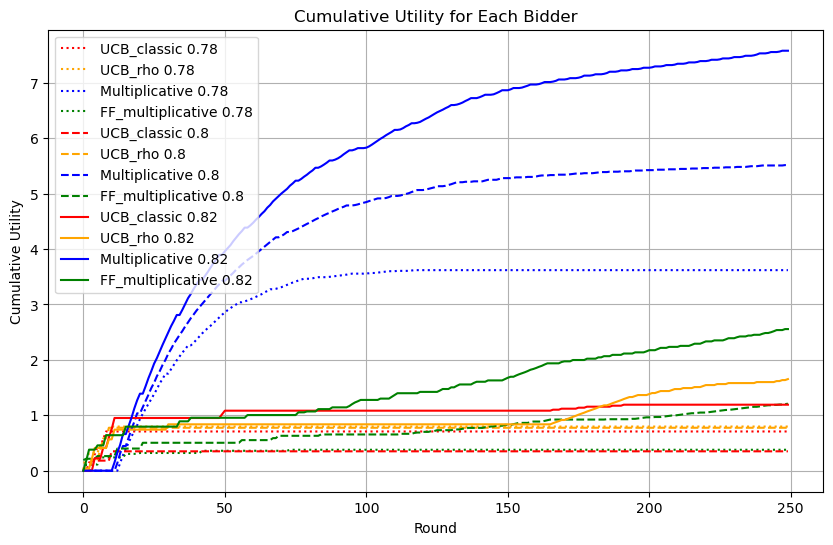

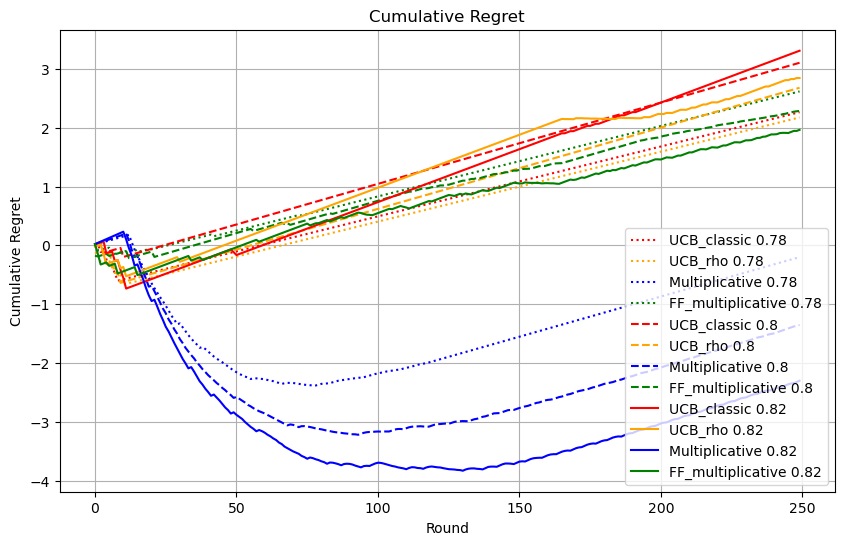

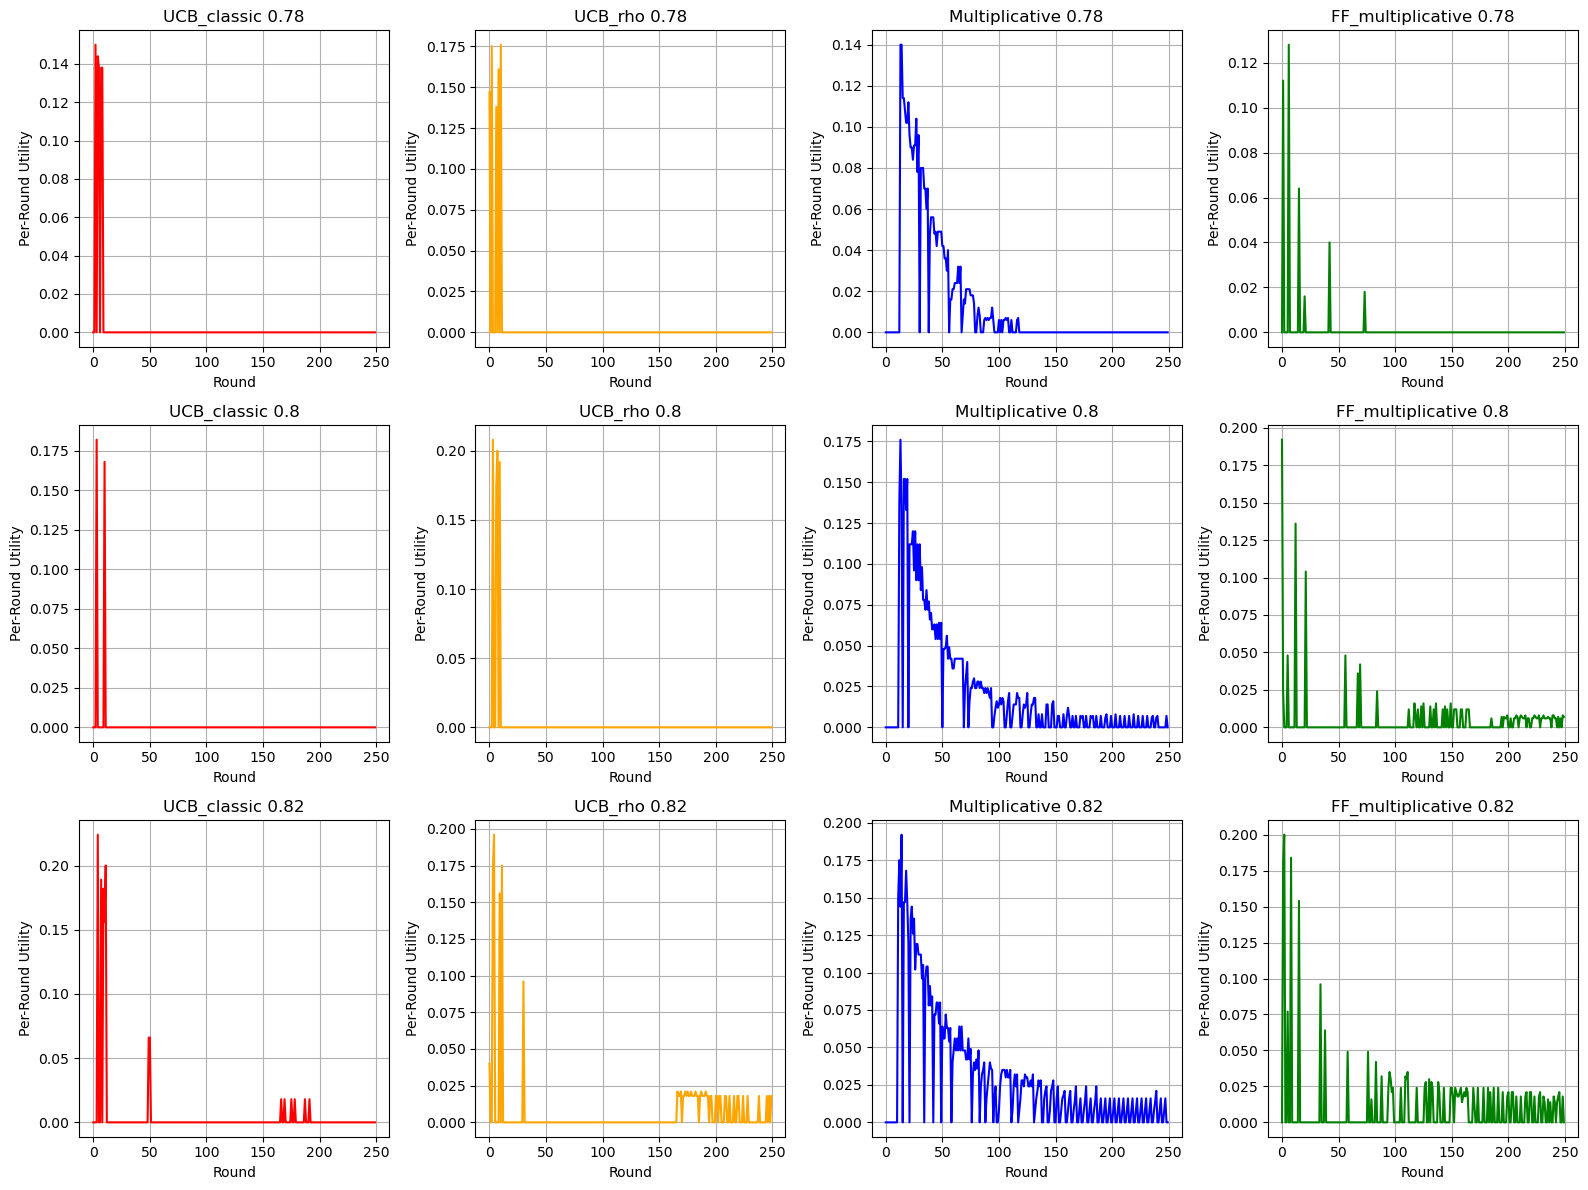

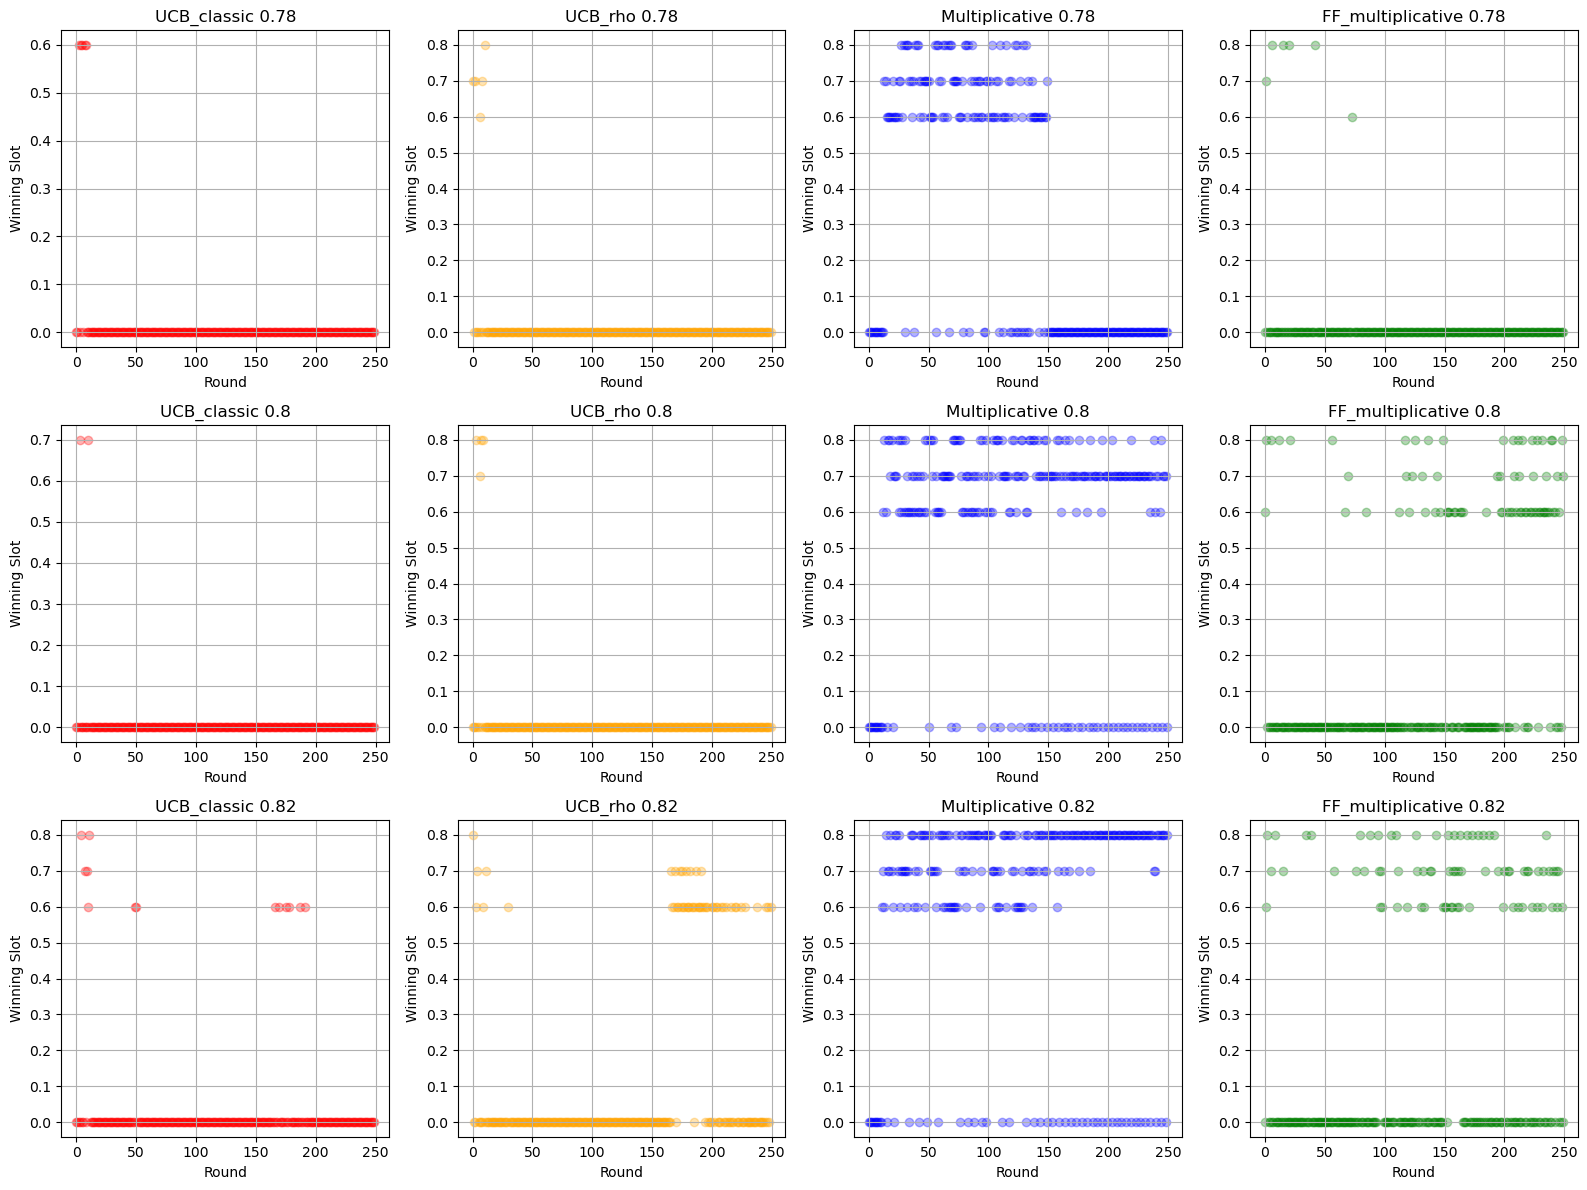

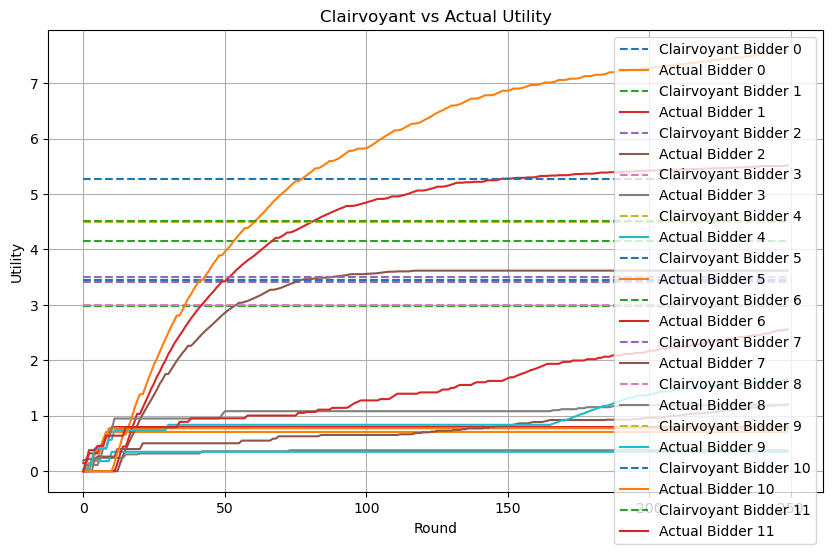

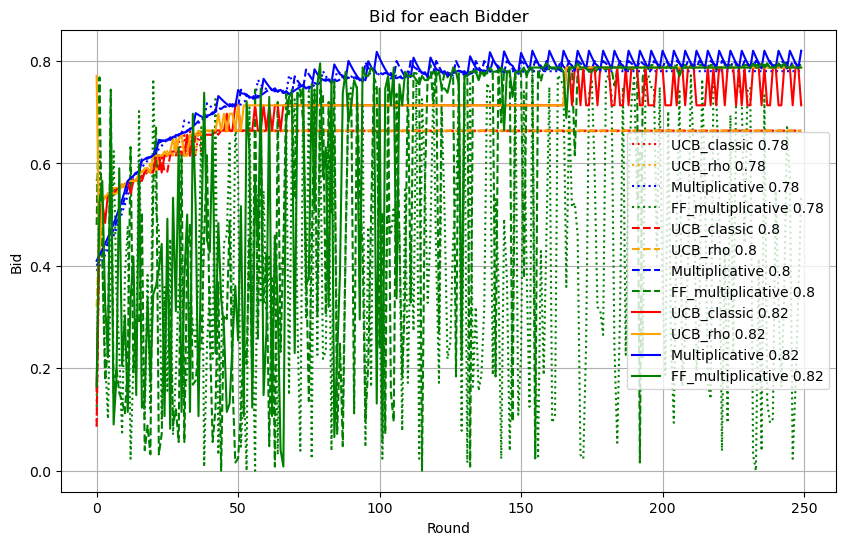

In [38]:
n_users = 250
lambdas = [0.6, 0.7, 0.8] # 2 slots
valuations = [0.78, 0.8, 0.82]
rho = 0.5
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations}

random.seed(42)

req = Requirement4(problem_params)
req.run()